Часть 2: Базовая U-Net на датасете "Луна"
2.1 Загрузка данных сегментации

Требования к архитектуре U-Net (зафиксируйте и опишите в отчёте):
Глубина: 4 уровня down/4 up (энкодер-декодер с skip-связями).
Базовые каналы на первом уровне: 32 или 64 (по желанию можно выбрать свое количество каналов, но надо будет объяснить).
Даунсемплинг: stride 2 или MaxPool.
Итоговый слой: 1 канал с сигмоидой (бинарная сегментация).
Ограничение на количество параметров: до ~2.5M (рекомендуется укладываться, но допускается ±10%).
Вход: 128×128×3.
Обучение:
Лосс: BCEWithLogitsLoss или Dice Loss, допустимо комбинировать (например, 0.5BCE + 0.5Dice).
Метрики для мониторинга: IoU (Jaccard), Dice, Pixel Accuracy.
Аугментации: горизонтальные/вертикальные флипы, лёгкие геометрические и цветовые — по желанию (можно добавлять другие).
Что сдаём по части 2:
Логи обучения и итоговые метрики на валидации: IoU, Dice, Pixel Acc.
3–5 визуализаций: вход, предсказанная маска, GT маска.

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd


In [7]:
!unzip -q /content/MOON_SEGMENTATION_BINARY.zip -d /content/

In [8]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


MOON_DATA_PATH = './MOON_SEGMENTATION_BINARY'
CHECKPOINT_DIR = './checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Всего изображений: 1000
Train: 800 изображений
Val: 200 изображений


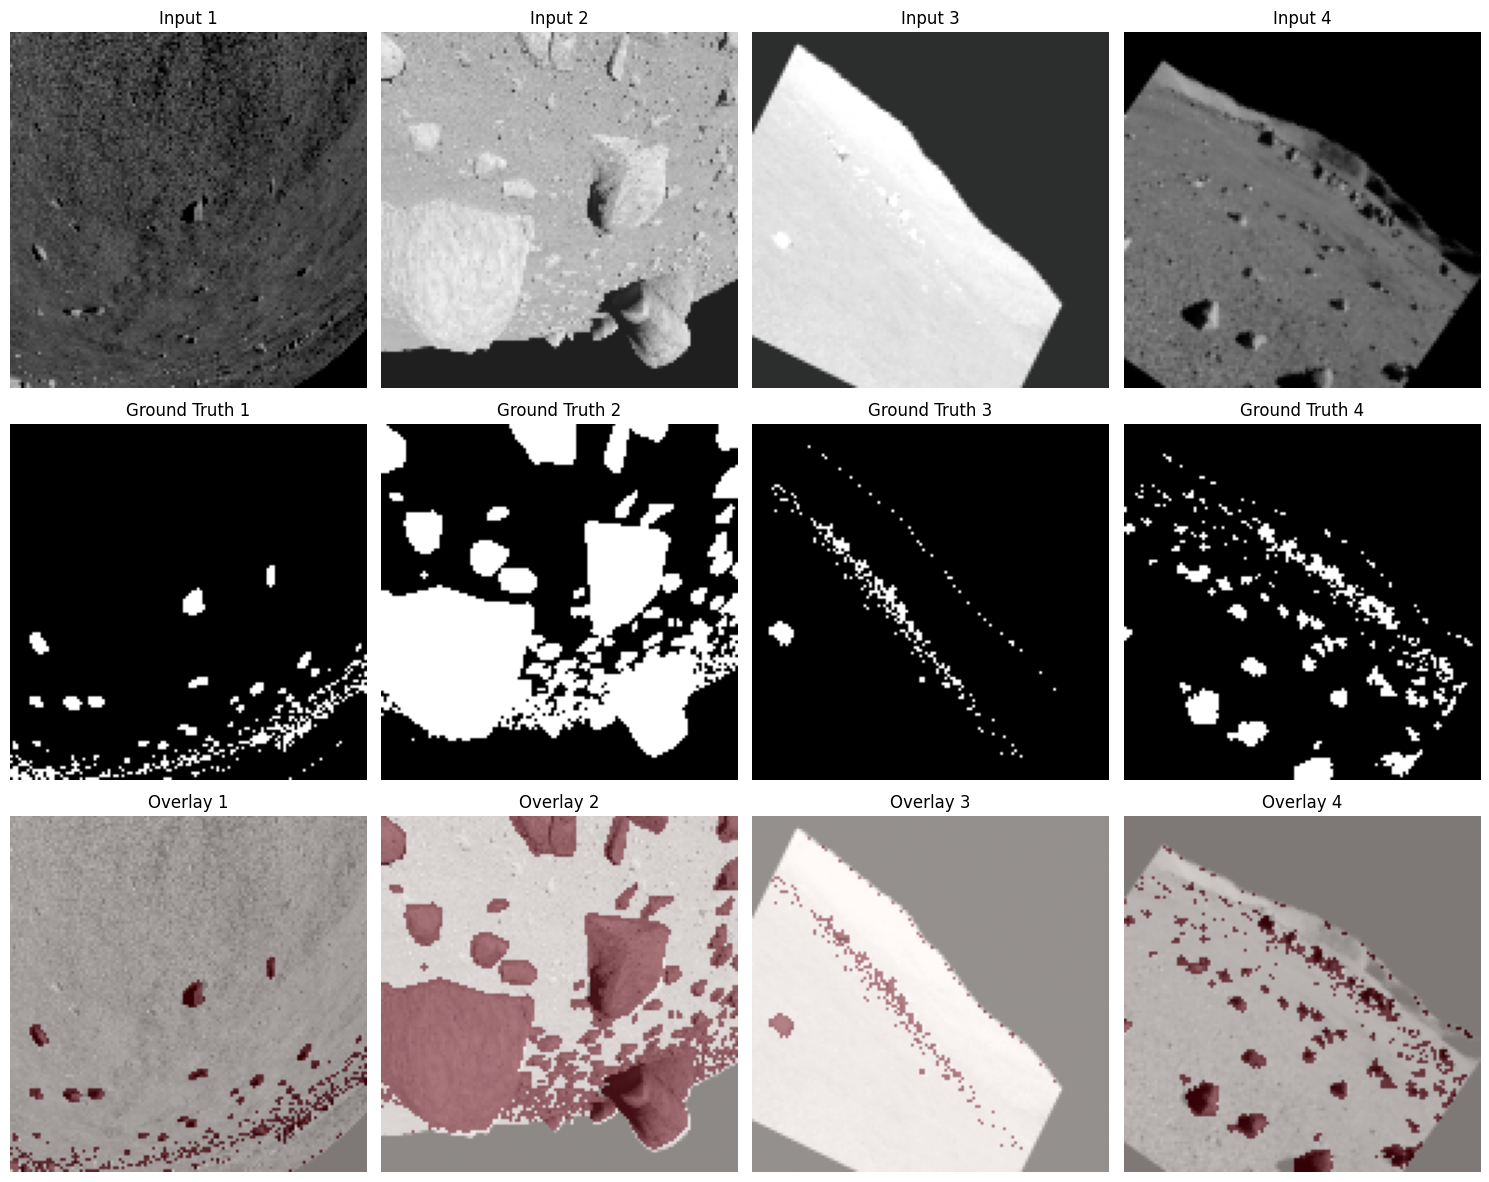

In [10]:
class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground',
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = augmentation
        self.preprocessing = preprocessing

        images_dir = os.path.join(root_dir, 'images', image_folder)
        all_images_names = os.listdir(images_dir)

        # Filter for .png files and remove extension
        self.image_ids = [img.replace('.png', '') for img in all_images_names if img.endswith('.png')]

        # If specific image_ids are provided, filter the loaded ones.
        if image_ids is not None:
            self.image_ids = [id for id in self.image_ids if id in image_ids]


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")

        # Adjusted mask_id construction based on observed file names
        # Assuming mask_id is just the number if image_id is 'renderXXXX'
        mask_number = ''.join(filter(str.isdigit, image_id))
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_number}.png")

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        mask = (mask > 0).astype(np.float32)

        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

train_augmentation = A.Compose([
    A.Resize(128, 128), # Changed to 128x128
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

preprocessing = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation = A.Compose([
    A.Resize(128, 128), # Changed to 128x128
])

def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

images_dir = os.path.join(MOON_DATA_PATH, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")

train_dataset = MoonSegmentationDataset(
    root_dir=MOON_DATA_PATH,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=MOON_DATA_PATH,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)

batch_size = 10

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

fig, axes = plt.subplots(3, 4, figsize=(15, 12))
for i in range(4):
    img, mask = train_dataset[i*10]

    img_display = denormalize(img)
    img_display = img_display.permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)

    axes[0, i].imshow(img_display)
    axes[0, i].set_title(f'Input {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(mask.squeeze(), cmap='gray')
    axes[1, i].set_title(f'Ground Truth {i+1}')
    axes[1, i].axis('off')

    axes[2, i].imshow(img_display)
    axes[2, i].imshow(mask.squeeze(), cmap='Reds', alpha=0.5)
    axes[2, i].set_title(f'Overlay {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

2.2 Архитектура базовой U-Net

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(DoubleConv(prev_channels, feature))
            prev_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                DoubleConv(feature * 2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")

    def forward(self, x):

        skip_connections = []

        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)

            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:],
                                mode='bilinear', align_corners=True)

            x = torch.cat([skip_connection, x], dim=1)

            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)

        return output


model = UNet(in_channels=3, out_channels=1, features=[64, 128, 256, 512])

test_input = torch.randn(1, 3, 256, 256)
test_output = model(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

Параметров: 31,043,521
Уровней encoder: 4
Конфигурация каналов: [64, 128, 256, 512]
   Вход:  torch.Size([1, 3, 256, 256])
   Выход: torch.Size([1, 1, 256, 256])


In [12]:
total_params_unet = sum(p.numel() for p in model.parameters())
print(total_params_unet)

31043521


2.3 Функции потерь и метрики

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

def calculate_iou(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

def calculate_dice(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)

    return dice.item()

def calculate_pixel_accuracy(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    correct = (pred == target).float().sum()
    total = target.numel()

    return (correct / total).item()

2.4 Обучение базовой U-Net

In [14]:
def train_unet(model, train_loader, val_loader, num_epochs=10, lr=0.001, model_name='unet'):
    criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                                      patience=5)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_iou': [],
        'val_dice': [],
        'val_pixel_acc': []
    }

    best_val_iou = 0.0
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)
            masks = masks.unsqueeze(1) # Add channel dimension

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            pbar.set_postfix({'loss': loss.item()})

        train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_iou_sum = 0.0
        val_dice_sum = 0.0
        val_pixel_acc_sum = 0.0

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
                images, masks = images.to(device), masks.to(device)
                masks = masks.unsqueeze(1) # Add channel dimension
                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item() * images.size(0)

                for i in range(outputs.size(0)):
                    val_iou_sum += calculate_iou(outputs[i], masks[i])
                    val_dice_sum += calculate_dice(outputs[i], masks[i])
                    val_pixel_acc_sum += calculate_pixel_accuracy(outputs[i], masks[i])

        val_loss = val_loss / len(val_loader.dataset)
        val_iou = val_iou_sum / len(val_loader.dataset)
        val_dice = val_dice_sum / len(val_loader.dataset)
        val_pixel_acc = val_pixel_acc_sum / len(val_loader.dataset)

        scheduler.step(val_iou)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)
        history['val_dice'].append(val_dice)
        history['val_pixel_acc'].append(val_pixel_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Val Loss: {val_loss:.4f}')
        print(f'  Val IoU: {val_iou:.4f}, Dice: {val_dice:.4f}, Pixel Acc: {val_pixel_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]['lr']:.6f}')

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': val_iou,
                'val_dice': val_dice,
                'val_pixel_acc': val_pixel_acc,
            }, os.path.join(CHECKPOINT_DIR, f'best_{model_name}.pth'))
            print(f'Best model saved! (Val IoU: {val_iou:.4f})')

        print()

    return history

history_unet_basic = train_unet(model, train_loader, val_loader,
                                num_epochs=10, lr=0.001, model_name='unet_basic')

Epoch 1/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  5.96it/s]


Epoch 1/10:
  Train Loss: 0.5404
  Val Loss: 0.4797
  Val IoU: 0.2217, Dice: 0.3393, Pixel Acc: 0.9013
  LR: 0.001000
Best model saved! (Val IoU: 0.2217)



Epoch 2/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


Epoch 2/10:
  Train Loss: 0.4687
  Val Loss: 0.5368
  Val IoU: 0.2260, Dice: 0.3471, Pixel Acc: 0.7890
  LR: 0.001000
Best model saved! (Val IoU: 0.2260)



Epoch 3/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]


Epoch 3/10:
  Train Loss: 0.4480
  Val Loss: 0.4505
  Val IoU: 0.2565, Dice: 0.3896, Pixel Acc: 0.9072
  LR: 0.001000
Best model saved! (Val IoU: 0.2565)



Epoch 4/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.17it/s]


Epoch 4/10:
  Train Loss: 0.4183
  Val Loss: 0.3786
  Val IoU: 0.3336, Dice: 0.4771, Pixel Acc: 0.9142
  LR: 0.001000
Best model saved! (Val IoU: 0.3336)



Epoch 5/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.44it/s]


Epoch 5/10:
  Train Loss: 0.4110
  Val Loss: 0.3890
  Val IoU: 0.3363, Dice: 0.4780, Pixel Acc: 0.9088
  LR: 0.001000
Best model saved! (Val IoU: 0.3363)



Epoch 6/10 [Val]: 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Epoch 6/10:
  Train Loss: 0.4065
  Val Loss: 0.4148
  Val IoU: 0.3018, Dice: 0.4446, Pixel Acc: 0.9015
  LR: 0.001000



Epoch 7/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.11it/s]


Epoch 7/10:
  Train Loss: 0.4040
  Val Loss: 0.3797
  Val IoU: 0.3329, Dice: 0.4774, Pixel Acc: 0.9118
  LR: 0.001000



Epoch 8/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


Epoch 8/10:
  Train Loss: 0.3997
  Val Loss: 0.3811
  Val IoU: 0.3120, Dice: 0.4497, Pixel Acc: 0.9171
  LR: 0.001000



Epoch 9/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.45it/s]


Epoch 9/10:
  Train Loss: 0.4008
  Val Loss: 0.3892
  Val IoU: 0.3390, Dice: 0.4831, Pixel Acc: 0.8955
  LR: 0.001000
Best model saved! (Val IoU: 0.3390)



Epoch 10/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.45it/s]

Epoch 10/10:
  Train Loss: 0.3929
  Val Loss: 0.3861
  Val IoU: 0.3138, Dice: 0.4528, Pixel Acc: 0.9176
  LR: 0.001000



Результаты и визуализация

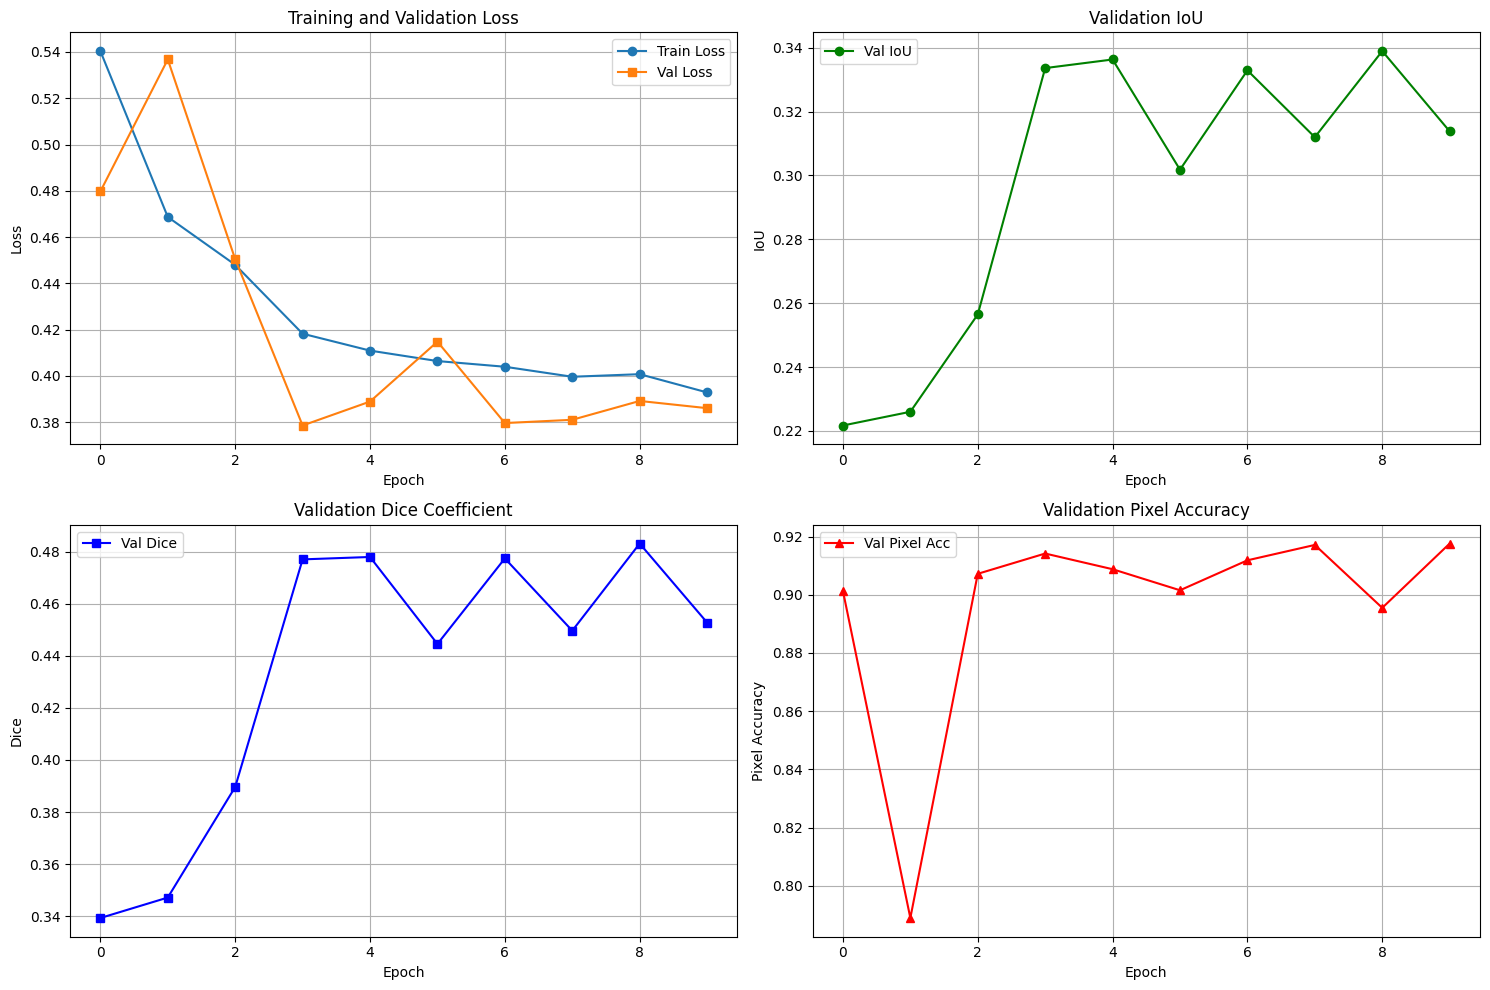

Best model loaded from epoch 9
Best validation IoU: 0.3390
Best validation Dice: 0.4831
Best validation Pixel Acc: 0.8955


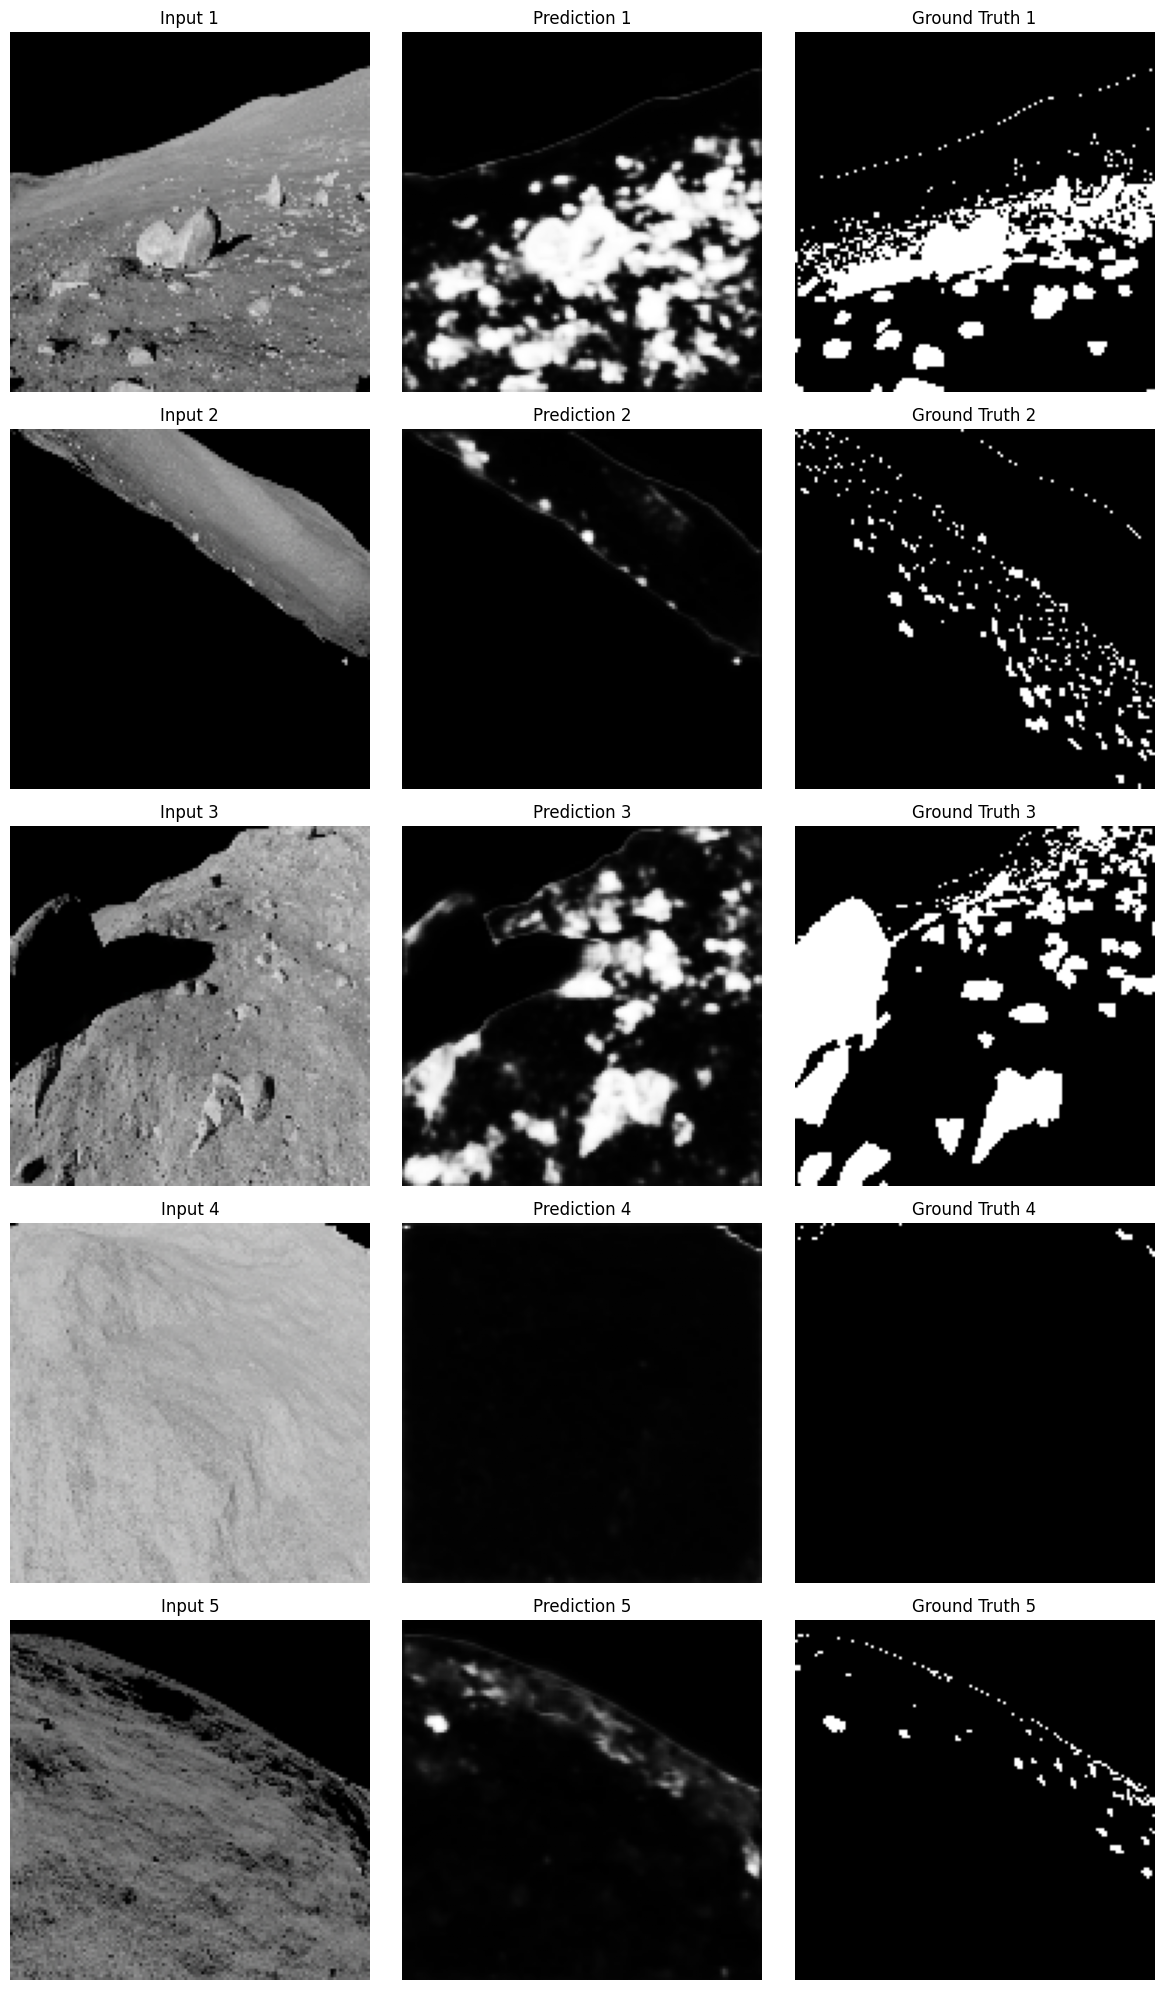

Final evaluation: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]


=== Part 2 Summary (Basic U-Net) ===
Best validation IoU: 0.3390
Best validation Dice: 0.4831
Best validation Pixel Acc: 0.8955
Final validation IoU: 0.3390
Final validation Dice: 0.4831
Final validation Pixel Acc: 0.8955


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history_unet_basic['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history_unet_basic['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history_unet_basic['val_iou'], label='Val IoU', marker='o', color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('IoU')
axes[0, 1].set_title('Validation IoU')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(history_unet_basic['val_dice'], label='Val Dice', marker='s', color='blue')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Dice')
axes[1, 0].set_title('Validation Dice Coefficient')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history_unet_basic['val_pixel_acc'], label='Val Pixel Acc', marker='^', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Pixel Accuracy')
axes[1, 1].set_title('Validation Pixel Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

checkpoint_unet = torch.load(os.path.join(CHECKPOINT_DIR, 'best_unet_basic.pth'))
model.load_state_dict(checkpoint_unet['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint_unet['epoch']+1}")
print(f"Best validation IoU: {checkpoint_unet['val_iou']:.4f}")
print(f"Best validation Dice: {checkpoint_unet['val_dice']:.4f}")
print(f"Best validation Pixel Acc: {checkpoint_unet['val_pixel_acc']:.4f}")

model.eval()
fig, axes = plt.subplots(5, 3, figsize=(12, 20))

with torch.no_grad():
    for i in range(5):
        img, mask = val_dataset[i*10]
        img_tensor = img.unsqueeze(0).to(device)

        output = model(img_tensor)
        pred_mask = torch.sigmoid(output).squeeze().cpu()

        img_display = denormalize(img)
        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f'Input {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(pred_mask, cmap='gray')
        axes[i, 1].set_title(f'Prediction {i+1}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask.squeeze(), cmap='gray')
        axes[i, 2].set_title(f'Ground Truth {i+1}')
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

model.eval()
final_iou = 0.0
final_dice = 0.0
final_pixel_acc = 0.0
num_samples = 0

with torch.no_grad():
    for images, masks in tqdm(val_loader, desc='Final evaluation'):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        for i in range(outputs.size(0)):
            final_iou += calculate_iou(outputs[i], masks[i])
            final_dice += calculate_dice(outputs[i], masks[i])
            final_pixel_acc += calculate_pixel_accuracy(outputs[i], masks[i])
            num_samples += 1

final_iou /= num_samples
final_dice /= num_samples
final_pixel_acc /= num_samples

print('\n=== Part 2 Summary (Basic U-Net) ===')
print(f'Best validation IoU: {checkpoint_unet["val_iou"]:.4f}')
print(f'Best validation Dice: {checkpoint_unet["val_dice"]:.4f}')
print(f'Best validation Pixel Acc: {checkpoint_unet["val_pixel_acc"]:.4f}')
print(f'Final validation IoU: {final_iou:.4f}')
print(f'Final validation Dice: {final_dice:.4f}')
print(f'Final validation Pixel Acc: {final_pixel_acc:.4f}')


Часть 3. U-Net с бэкбоном из классификатора